# Transfer Learning avec **MobileNetV2**

In [ ]:
!pip show tensorflow
!pip show keras

Name: tensorflow
Version: 2.18.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tensorflow-text, tensorflow_decision_forests, tf_keras
Name: keras
Version: 3.8.0
Summary: Multi-backend Keras
Home-page: 
Author: 
Author-email: Keras team <keras-users@googlegroups.com>
License: Apache License 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: absl-py, h5py, ml-dtypes, namex, numpy, optree, packaging, rich
Required-by: tensorflow


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import drive
from collections import Counter
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall, AUC
import os


drive.mount('/content/drive')

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
DATASET_PATH = "/content/drive/MyDrive/Projet-ML/dataset_corrige_animals"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Affichage de la distribution des classes

{'injured_animals': 261, 'not_injured_animals': 282}


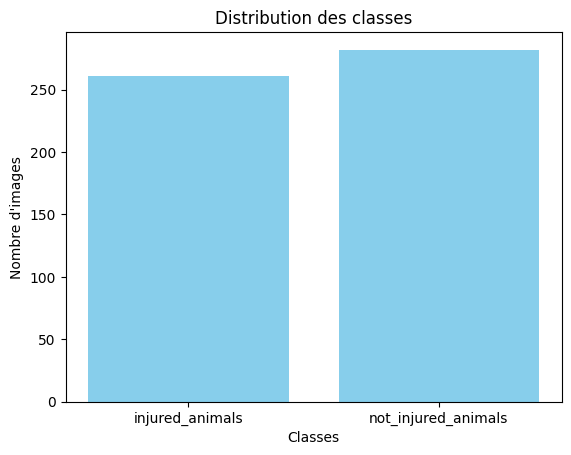

In [ ]:
class_names = os.listdir(DATASET_PATH)

count_dict = {}
for class_name in class_names:
    class_path = os.path.join(DATASET_PATH, class_name)
    count_dict[class_name] = len(os.listdir(class_path))

print(count_dict)

plt.bar(count_dict.keys(), count_dict.values(), color='skyblue')
plt.title("Distribution des classes")
plt.xlabel("Classes")
plt.ylabel("Nombre d'images")
plt.show()

# Création de datasets train / val

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.3,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 543 files belonging to 2 classes.
Using 381 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.3,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 543 files belonging to 2 classes.
Using 162 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['injured_animals', 'not_injured_animals']


# Augmentation des données

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

## Exemple d'une image transformée avec le bloc data_augmentation

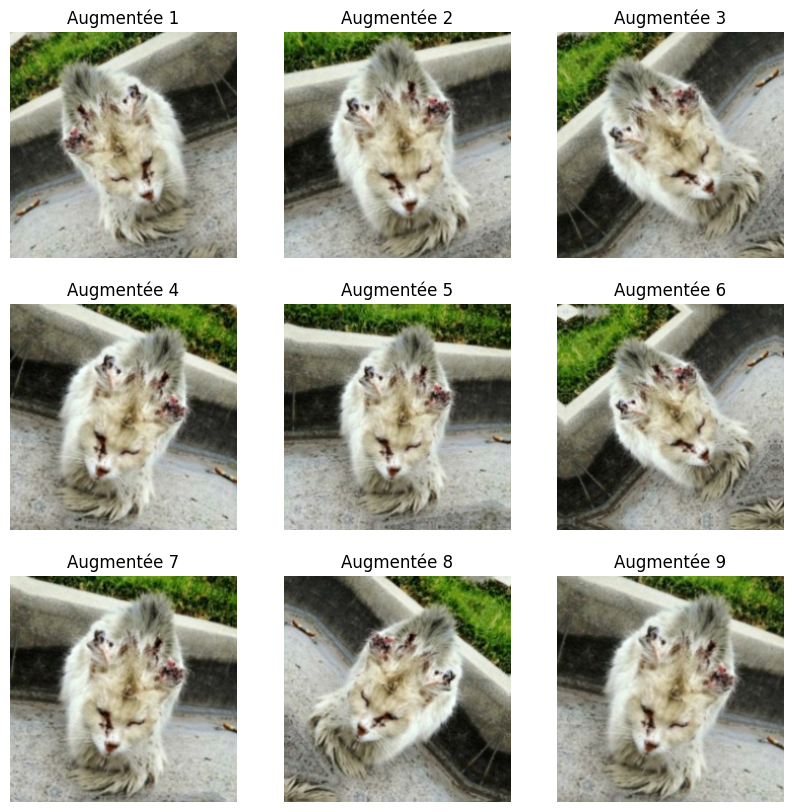

In [ ]:
import numpy as np

for images, _ in train_ds.take(1):
    sample_image = images[0]
    break

plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = data_augmentation(tf.expand_dims(sample_image, 0))
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(tf.cast(augmented_image[0], tf.uint8))
    plt.title(f"Augmentée {i+1}")
    plt.axis("off")
plt.show()

# Chargement de MobileNetV2 sans les couches de classification (top)

In [ ]:
base_model = MobileNetV2(input_shape=(224, 224, 3),
                         include_top=False,
                         weights='imagenet')


base_model.trainable = False

model_tl = models.Sequential([
    layers.Rescaling(1./255),              # Normalisation
    data_augmentation,                     # Augmentations d’images
    base_model,                            # Base MobileNetV2 gelée
    layers.GlobalAveragePooling2D(),       # Moyenne spatiale des features
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # Binaire : blessé ou non blessé
])

model_tl.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy', Precision(), Recall(), AUC()])

# Résumé du modèle
model_tl.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

# Entrainement du modèle

In [ ]:
history_tl = model_tl.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 65s 5s/step - accuracy: 0.5909 - auc: 0.6651 - loss: 0.7090 - precision: 0.6783 - recall: 0.4794 - val_accuracy: 0.5988 - val_auc: 0.6817 - val_loss: 0.6458 - val_precision: 0.6528 - val_recall: 0.5402
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.6747 - auc: 0.7659 - loss: 0.6050 - precision: 0.7660 - recall: 0.5192 - val_accuracy: 0.6852 - val_auc: 0.7572 - val_loss: 0.5761 - val_precision: 0.6957 - val_recall: 0.7356
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.6844 - auc: 0.7545 - loss: 0.5907 - precision: 0.6704 - recall: 0.7063 - val_accuracy: 0.7593 - val_auc: 0.8108 - val_loss: 0.5277 - val_precision: 0.7264 - val_recall: 0.8851
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.7737 - auc: 0.8624 - loss: 0.4643 - precision: 0.7649 - recall: 0.8164 - val_accuracy: 0.7716 - val_auc: 0.8557 - val_loss: 0.4801 - val_precision: 0.7778 - val_recall: 0.8046
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 31

# Les courbes des metriques d'évaluations

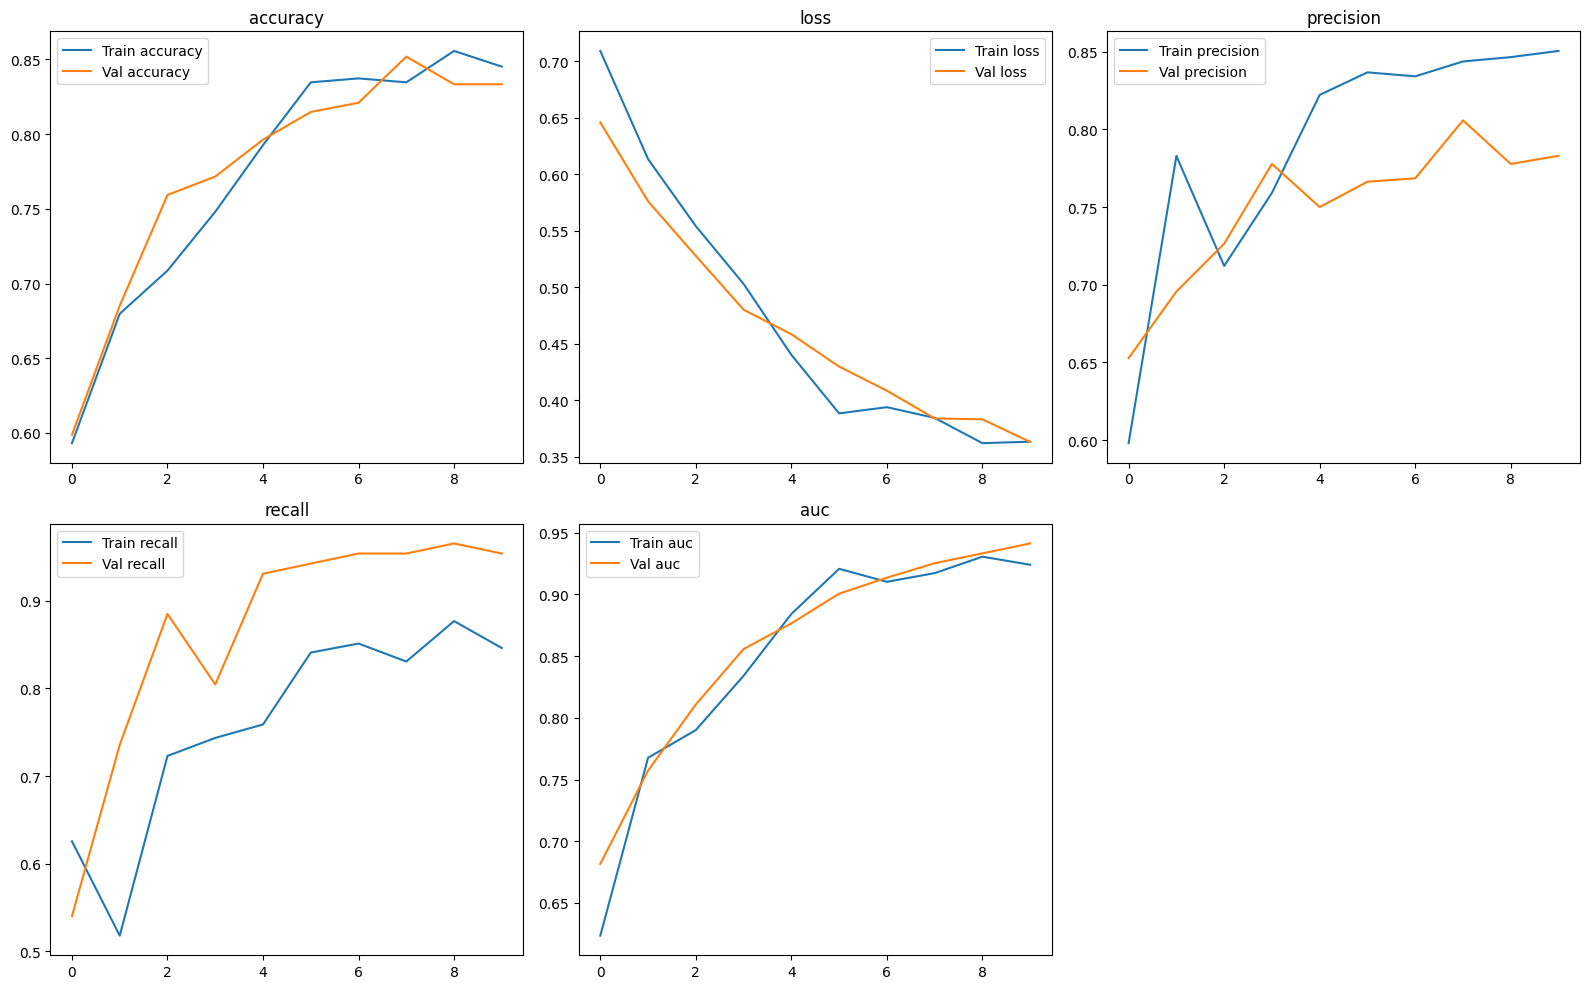

In [ ]:
import matplotlib.pyplot as plt
def plot_learning_curves(history):
    metrics = ['accuracy', 'loss', 'precision', 'recall', 'auc']
    plt.figure(figsize=(16, 10))
    for i, metric in enumerate(metrics):
        plt.subplot(2, 3, i + 1)
        plt.plot(history.history[metric], label=f'Train {metric}')
        plt.plot(history.history[f'val_{metric}'], label=f'Val {metric}')
        plt.legend()
        plt.title(metric)
    plt.tight_layout()
    plt.show()

plot_learning_curves(history_tl)

# Enregistrement du modèle

In [ ]:
model_tl.save("Animals_MobileNetV2.h5")

# Matrice de Confusion

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


<Figure size 600x600 with 0 Axes>

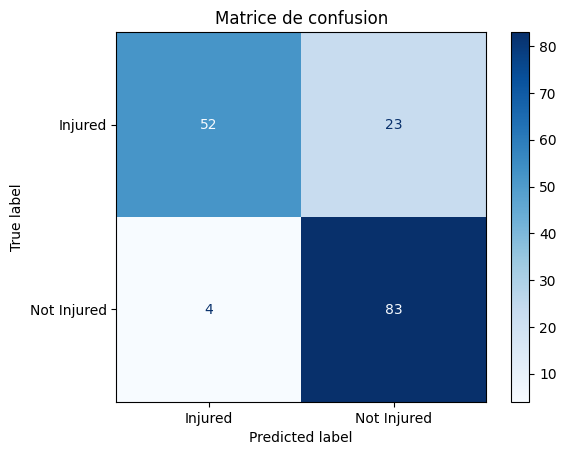

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model_tl.predict(images)
    preds_classes = (preds > 0.5).astype("int32")
    y_true.extend(labels.numpy())
    y_pred.extend(preds_classes.flatten())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Injured', 'Not Injured'])

plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Matrice de confusion")
plt.show()

# Rapport de classification

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=['Injured', 'Not Injured']))

              precision    recall  f1-score   support

     Injured       0.93      0.84      0.88        75
 Not Injured       0.87      0.94      0.91        87

    accuracy                           0.90       162
   macro avg       0.90      0.89      0.89       162
weighted avg       0.90      0.90      0.89       162



# Afficher les erreurs du modèle

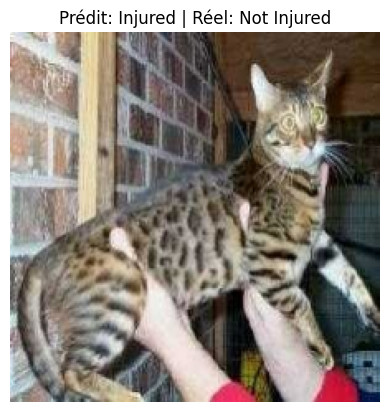

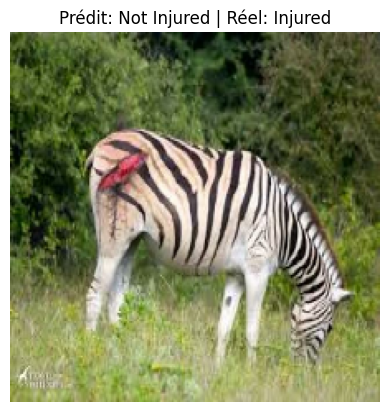

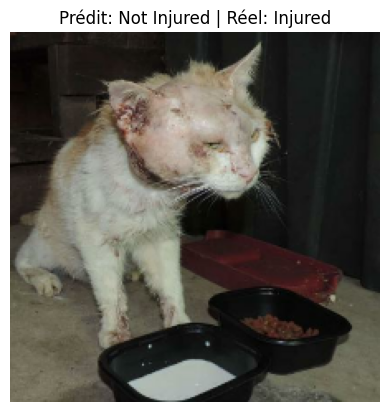

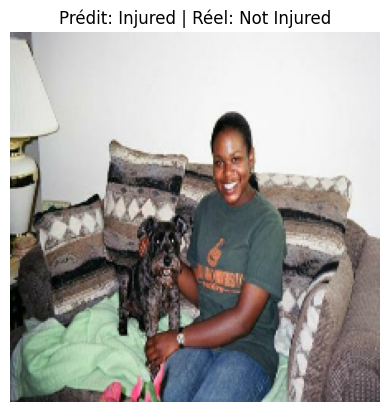

In [ ]:
val_ds_unbatched = val_ds.unbatch().take(30)

for i, (img, label) in enumerate(val_ds_unbatched):
    pred = model_tl.predict(tf.expand_dims(img, axis=0), verbose=0)[0][0]
    predicted_label = int(pred > 0.5)
    true_label = int(label.numpy())

    #  0 = 'injured_animals' = 'Blessé'
    #  1 = 'not_injured_animals' = 'Non blessé'
    if predicted_label != true_label:
        plt.imshow(img.numpy().astype("uint8"))
        plt.title(f"Prédit: {'Not Injured' if predicted_label == 1 else 'Injured'} | Réel: {'Not Injured' if true_label == 1 else 'Injured'}")
        plt.axis('off')
        plt.show()
